### Load Dataset

In [1]:
# 패키지 불러오기
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프 그리기 
%matplotlib inline

# 그래프 마이너스 폰트 깨짐 설정
mpl.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 불러오기
train = pd.read_csv("./bike-sharing-demand/train.csv", parse_dates=['datetime'])
train.shape

(10886, 12)

In [3]:
test = pd.read_csv("./bike-sharing-demand/test.csv", parse_dates=['datetime'])
test.shape

(6493, 9)

### Feature Engineering

In [4]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [5]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 16)

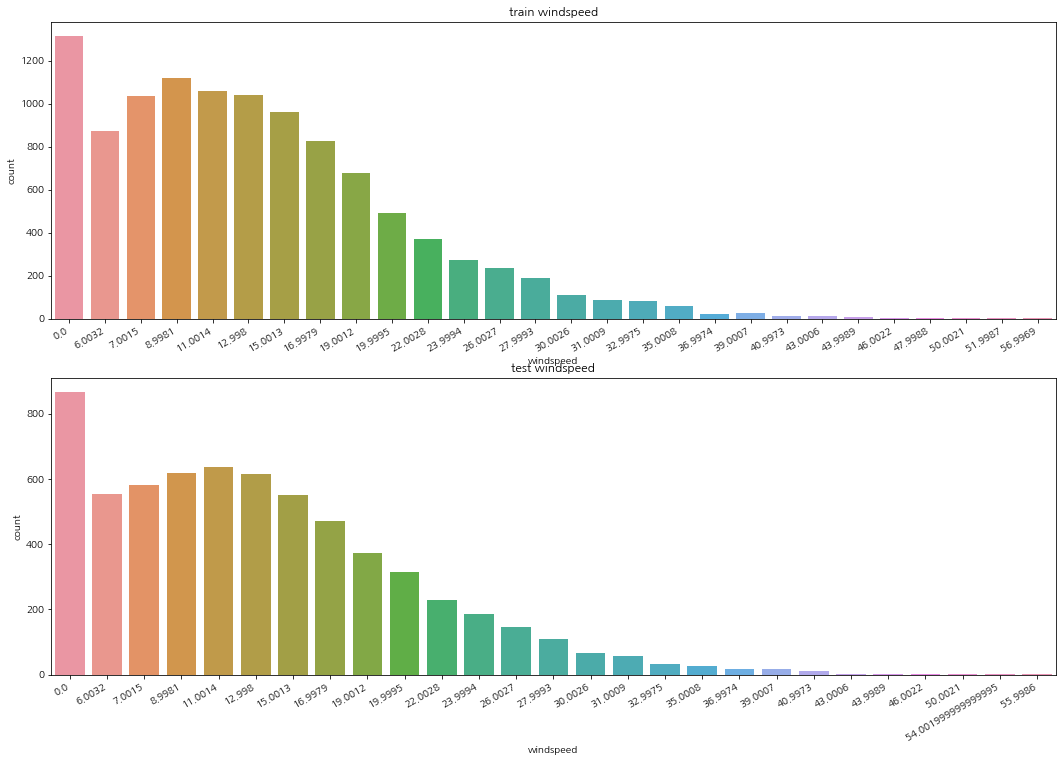

In [6]:
# windspeed 풍속에 0 값이 가장 많음 -> 잘못 기록된 데이터 고칠 필요가 있음.
fig, axes = plt.subplots(nrows=2)
fig.set_size_inches(18,12)

plt.sca(axes[0])
plt.xticks(rotation=30, ha='right')
axes[0].set(ylabel="Count", title="train windspeed")
sns.countplot(data=train, x='windspeed', ax=axes[0])

plt.sca(axes[1])
plt.xticks(rotation=30, ha='right')
axes[1].set(ylabel="Count", title="test windspeed")
sns.countplot(data=test, x='windspeed', ax=axes[1])

plt.show()

- train 데이터 뿐만 아니라 test 데이터에도 windspeed값이 0인 데이터가 많은 것을 확인할 수 있다.   
- 측정되지 않은 데이터들을 0으로 입력했을 것이라고 예측하고 보정하기로 함.
- 0인 값을 평균으로 대치하는 것은 예측의 정확도를 높이는 데 도움이 될 것 같진 않음.

In [8]:
# 풍속이 0인것과 아닌 것 나누기
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 19)
(9573, 19)


In [9]:
# 머신러닝으로 예측을 통해 풍속 값을 채우기로 함.
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    # 0인 값과 아닌 것 나누기
    dataWind0 = data.loc[data['windspeed']==0]
    dataWindNot0 = data.loc[data['windspeed']!=0]
    
    # 풍속 예측할 피처 선택
    wCol = ['season', 'weather', 'humidity', 'month', 'temp', 'year', 'atemp']
    
    # 풍속이 0이 아닌 데이터들 타입 string으로 변경
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')
    
    # 랜덤포레스트 분류기 사용
    rfModel_wind = RandomForestClassifier()
    
    # wCol에 있는 피처 값 바탕으로 모델 학습
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    
    # 학습한 값 바탕으로 풍속이 0으로 기록된 데이터 풍속 예측
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])
    
    # 비교를 위해 예측 값 넣을 데이터 프레임 생성
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    # 0인 풍속값에 예측값 대입
    predictWind0['windspeed'] = wind0Values
    
    # 0이 아닌 풍속값 데이터와 예측값 데이터프레임 합치기
    data = predictWindNot0.append(predictWind0)
    
    # 풍속 데이터타입 float로 지정
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

<AxesSubplot:title={'center':'train windspeed'}, xlabel='windspeed', ylabel='count'>

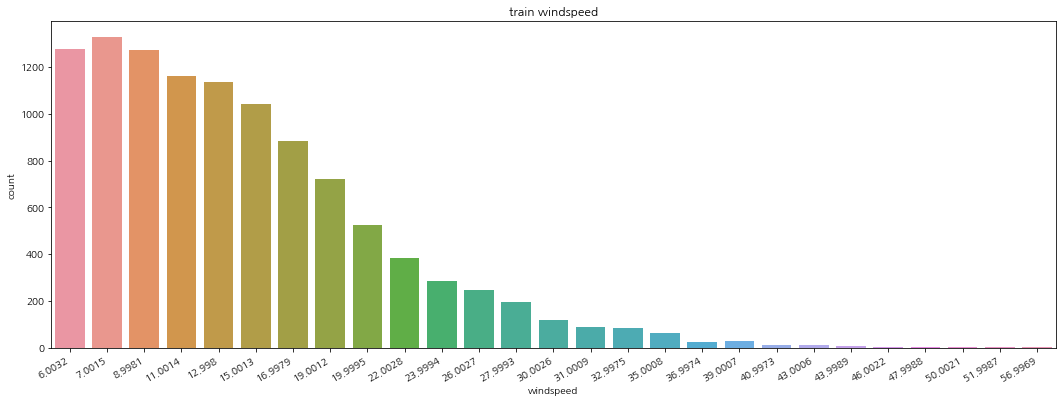

In [10]:
# 0값 조정
train = predict_windspeed(train)

# windspeed의 0값 조정한 데이터 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel = 'Count', title='train windspeed')
sns.countplot(data=train, x='windspeed', ax=ax1)

값이 0이었던 데이터들이 예측값으로 대체된 것을 확인할 수 있다.